### Cleanup Algorithm Divisons Output

Here I take the best index generated by the algorithm, reassign the club numbers and locations, assign areas, and plot the result.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import random

import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from grouping_functions import select_grouping_function
from assignment_functions import select_assignment_function

In [2]:
best_index = [18, 20, 4, 32, 6, 33, 2, 30, 7, 10, 28, 5, 31, 23, 24, 17, 3, 12, 25, 9, 15, 0, 22, 13, 21, 8, 26, 11, 1, 14, 27, 19, 16, 29]

In [3]:
grouping = select_grouping_function(len(best_index))

In [4]:
divisions_groups = list(grouping(best_index))

In [5]:
divisions_groups

[[18, 20, 4, 32, 6],
 [33, 2, 30, 7, 10],
 [28, 5, 31, 23, 24],
 [17, 3, 12, 25, 9],
 [15, 0, 22, 13, 21],
 [8, 26, 11, 1, 14],
 [27, 19, 16, 29]]

In [6]:
divisions = pd.DataFrame(best_index, columns = ['area'])
divisions.head()

,area
0,18
1,20
2,4
3,32
4,6


### Assign divisions to the areas

In [7]:
assign_divisions = select_assignment_function(len(best_index))

In [8]:
divisions['division'] = assign_divisions(best_index)

In [9]:
divisions.head()

,area,division
0,18,1
1,20,1
2,4,1
3,32,1
4,6,1


In [12]:
# The areas are zero-indexed so add 1 to all
divisions.area += 1

### Join to Clubs

In [32]:
with open('../data/area_clubs.pkl', 'rb') as f:  
    area_clubs = pickle.load(f)

In [33]:
area_clubs.head()

,club_no,lat,long,area
0,4108,32.879149,-96.744115,1
1,4110,32.880272,-96.745039,1
2,7533,32.912718,-96.734120,1
3,2923054,32.880281,-96.744544,1
4,7402713,32.879856,-96.743530,1


In [34]:
best_dist = (area_clubs.merge(divisions, on='area')
                .sort_values(['division', 'area', 'club_no'])
                .reset_index(drop=True))

In [35]:
best_dist

,club_no,lat,long,area,division
0,9354,33.057673,-96.093096,5,1
1,1526701,32.752683,-96.294835,5,1
2,1535564,33.057306,-96.092690,5,1
3,6654663,32.725325,-96.563118,5,1
4,7384295,32.730131,-96.446200,5,1
...,...,...,...,...,...
163,437,32.661445,-96.875097,30,7
164,583467,32.323023,-96.782143,30,7
165,2038660,32.656765,-96.840938,30,7
166,3431353,32.602043,-96.864659,30,7


In [36]:
assign_areas = select_assignment_function(len(best_dist))

In [37]:
assign_areas

<function assignment_functions.assign_areas_three_left(clubs)>

In [38]:
df = best_dist.copy()

In [39]:
def remap_areas(df):
    remapping = []
    # Iterate through each division number
    for d in df.division.unique():
        i = 0
        # Iteration through each area number in the division
        for a in df[df.division == d].area.unique():
            remapping.append(d * 10 + i)
            i += 1
    # Map the new area numbers to the old
    df2 = pd.DataFrame({'new_area': remapping,
                        'area': df.area.unique()})
    # Merge those and clean up
    df3 = df.merge(df2, on='area').drop('area', axis=1).rename(columns={'new_area': 'area'})
    
    return df3[['club_no', 'area', 'division', 'lat', 'long']]

In [40]:
new_district = remap_areas(best_dist)

In [41]:
new_district.head()

,club_no,area,division,lat,long
0,9354,10,1,33.057673,-96.093096
1,1526701,10,1,32.752683,-96.294835
2,1535564,10,1,33.057306,-96.092690
3,6654663,10,1,32.725325,-96.563118
4,7384295,10,1,32.730131,-96.446200


### Map and Save Resulting District

In [23]:
extent = (-97.0, -93.3, 32.1, 33.7)

In [42]:
# Convert the clubs dataframe to a geodataframe
g_clubs = gpd.GeoDataFrame(new_district, 
                           geometry=gpd.points_from_xy(
                               new_district.long, new_district.lat),
                           crs="EPSG:4326")
g_clubs.to_file('../data/new_clubs.shp')

In [43]:
# Make area boundaries
g_areas = g_clubs.dissolve(by='area')['geometry']
area_poly = g_areas.convex_hull.buffer(0.02)
area_boundaries = area_poly.boundary
area_boundaries.to_file('../data/new_areas.shp')

In [44]:
# Repeat with divisions
g_divisions = g_clubs.dissolve(by='division')['geometry']
division_poly = g_divisions.convex_hull.buffer(0.03)
division_boundaries = division_poly.boundary
division_boundaries.to_file('../data/new_divisions.shp')

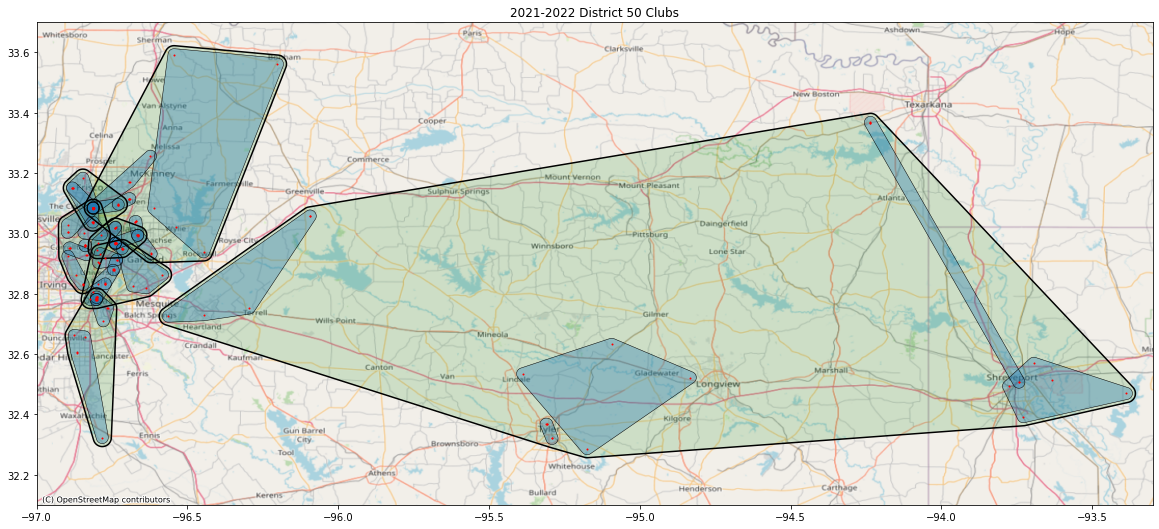

In [46]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.axis(extent)
ax.set_title('2021-2022 District 50 Clubs')
ax.plot(g_clubs.long, g_clubs.lat, 'o', markersize=1, color='red')
division_poly.plot(ax=ax, alpha=0.15, color='green')
division_boundaries.plot(ax=ax, color='black')
area_poly.plot(ax=ax, alpha=0.35)
area_boundaries.plot(ax=ax, color='black', linewidth=0.5)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)
plt.savefig('../outputs/D50_alignment_new.png', dpi=1200)
plt.show()

This district alignment looks okay, so export to csv.

In [47]:
new_district.to_csv('../data/new_district_alignment.csv', index=False)